In [ ]:
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
import seaborn as sns
import xarray as xr
from global_land_mask import globe

sns.set_context('paper')
sns.set_style('whitegrid')

# Load data

In [2]:
nam_weighted_centroids = xr.open_dataset('../input_preparation/outputs/nam_weighted_cao_centroids.nc')

In [3]:
extreme_cold_persist_thresh = xr.open_dataset('../input_preparation/outputs/ar6_3daypersist_extreme_cold_detrend_95thpercthresh_q01.nc')

In [4]:
t2m_detrended = xr.open_dataset('/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjm_era5_t2m_40to23Apr_detrended.nc')['t2m_detrended']
t2m_detrended['lon'] = (t2m_detrended['lon'] + 180) % 360 - 180
t2m_detrended = t2m_detrended.sortby('lon')
t2m_detrended = t2m_detrended.sortby('lat')

In [5]:
all_cold_event_codes = np.unique(extreme_cold_persist_thresh['cold_air_event_stacked_names'])

In [6]:
extreme_low_temp = xr.open_mfdataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/extreme_cold/extreme_low_temp_detrend_*q01.nc') 

In [7]:
coldairevent_code_to_names = {'000':'no', '001':'E', '010':'C', '011':'CE',\
                              '100':'W','110':'WC','101':'WE', '111':'WCE'}

In [8]:
NUM_DAYS_BREAK = 1


def cluster_datetimes(dates):
    clusters = []
    current_cluster = [dates[0].data]
    
    for i in range(1, len(dates)):
        if pd.to_timedelta(int(dates[i] - dates[i - 1])).days > NUM_DAYS_BREAK:
            # Start a new cluster
            clusters.append(current_cluster)
            current_cluster = [dates[i].data]
        else:
            # Add to the current cluster
            current_cluster.append(dates[i].data)
    
    # Add the last cluster
    clusters.append(current_cluster)
    
    return clusters


def make_centroid_season_df(centroid_df, season):
    for coldairevent_code in all_cold_event_codes:
        if coldairevent_code == '000':
            continue
        onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code)\
                                                ).dropna(dim='time')
        # Maybe histogram of cold air event types 
        onetype_coldair_event_season = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([season]))
        if onetype_coldair_event_season.time.size < 1:
            continue
        cold_air_event_dateclusters = cluster_datetimes(onetype_coldair_event_season.time)
        cold_air_oneevent_firstday = [cluster[0] for cluster in cold_air_event_dateclusters]
        nam_weighted_centroids_oneevent = nam_weighted_centroids.sel(time=cold_air_oneevent_firstday)
        nam_weighted_centroids_oneevent['lat'].load()

        nam_centroid_oneevent_df = pd.DataFrame(nam_weighted_centroids_oneevent['lat'].data).T
        nam_centroid_oneevent_df.columns = ['lat', 'lon']
        coldairevent_code = f'{coldairevent_code_to_names[coldairevent_code]} ({len(nam_centroid_oneevent_df)})'
        nam_centroid_oneevent_df['event'] = coldairevent_code
        centroid_df = pd.concat([centroid_df, nam_centroid_oneevent_df])
    centroid_df = centroid_df.reset_index(drop=True)
    return centroid_df

In [9]:
all_t2m_centroids_djf = pd.DataFrame()
all_t2m_centroids_mam = pd.DataFrame()
all_t2m_centroids_jja = pd.DataFrame()
all_t2m_centroids_son = pd.DataFrame()

In [10]:
%%time
all_t2m_centroids_djf= make_centroid_season_df(all_t2m_centroids_djf, 'DJF')
all_t2m_centroids_mam = make_centroid_season_df(all_t2m_centroids_mam, 'MAM')
all_t2m_centroids_jja = make_centroid_season_df(all_t2m_centroids_jja, 'JJA')
all_t2m_centroids_son = make_centroid_season_df(all_t2m_centroids_son, 'SON')

CPU times: user 11.7 s, sys: 37.8 ms, total: 11.7 s
Wall time: 11.7 s


# Make Figure 1 plot
## Make centroids

In [11]:
nam_regions = ["WNA", "CNA", "ENA"]

In [12]:
set2_cmap = sns.color_palette("Set2", 7)
set2_cmap

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451)]

In [13]:
lon_bins = np.arange(220, 302, 2)
lat_bins = np.arange(20, 72, 2)

In [14]:
lat_bins

array([20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52,
       54, 56, 58, 60, 62, 64, 66, 68, 70])

In [15]:
all_t2m_centroid_allseasons = pd.concat([all_t2m_centroids_djf, all_t2m_centroids_mam, all_t2m_centroids_jja, all_t2m_centroids_son])

In [16]:
density_djf, _, _ = np.histogram2d(all_t2m_centroids_djf['lon'],all_t2m_centroids_djf['lat'],[lon_bins,lat_bins])
density_mam, _, _ = np.histogram2d(all_t2m_centroids_mam['lon'],all_t2m_centroids_mam['lat'],[lon_bins,lat_bins])
density_jja, _, _ = np.histogram2d(all_t2m_centroids_jja['lon'],all_t2m_centroids_jja['lat'],[lon_bins,lat_bins])
density_son, _, _ = np.histogram2d(all_t2m_centroids_son['lon'],all_t2m_centroids_son['lat'],[lon_bins,lat_bins])

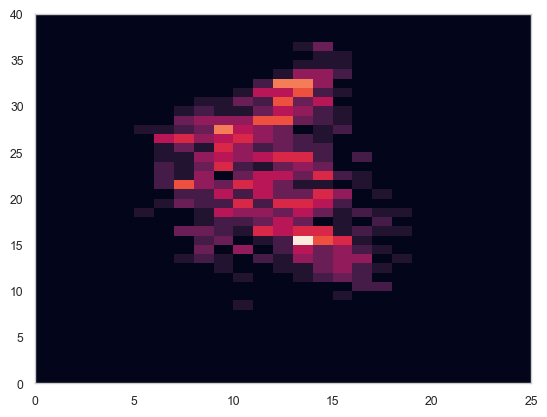

In [17]:
plt.pcolormesh(density_djf)

In [18]:
density_da_djf  = xr.DataArray(density_djf.T, dims=('lat', 'lon'))
density_da_djf['lat'] = lat_bins[:-1]
density_da_djf['lon'] = lon_bins[:-1]

density_da_mam  = xr.DataArray(density_mam.T, dims=('lat', 'lon'))
density_da_mam['lat'] = lat_bins[:-1]
density_da_mam['lon'] = lon_bins[:-1]

density_da_jja  = xr.DataArray(density_jja.T, dims=('lat', 'lon'))
density_da_jja['lat'] = lat_bins[:-1]
density_da_jja['lon'] = lon_bins[:-1]

density_da_son  = xr.DataArray(density_son.T, dims=('lat', 'lon'))
density_da_son['lat'] = lat_bins[:-1]
density_da_son['lon'] = lon_bins[:-1]

In [19]:
density_da_djf_nan = density_da_djf.where(density_da_djf > 0.1, np.nan)
density_da_mam_nan = density_da_mam.where(density_da_mam > 0.1, np.nan)
density_da_jja_nan = density_da_jja.where(density_da_jja > 0.1, np.nan)
density_da_son_nan = density_da_son.where(density_da_son > 0.1, np.nan)

In [20]:
if all_t2m_centroids_djf['lon'].min() > 0:
    print('converting')
    density_da_djf_nan['lon'] = (density_da_djf_nan['lon'] + 180) % 360 - 180
    all_t2m_centroids_djf['lon'] = (all_t2m_centroids_djf['lon'] + 180) % 360 - 180

converting


In [21]:
color_map = {'E (219)': set2_cmap[3], 'C (146)': set2_cmap[2], 'CE (45)': set2_cmap[0], 'W (132)': set2_cmap[1],\
            'WC (70)': set2_cmap[4], 'WE': set2_cmap[5], 'WCE (7)': set2_cmap[6]}
size_map = {'E (219)': 5, 'C (146)': 5, 'CE (45)': 10, 'W (132)': 5,\
            'WC (70)': 10, 'WE': 10, 'WCE (7)': 20}

Text(0.5, 1.0, 'DJF')

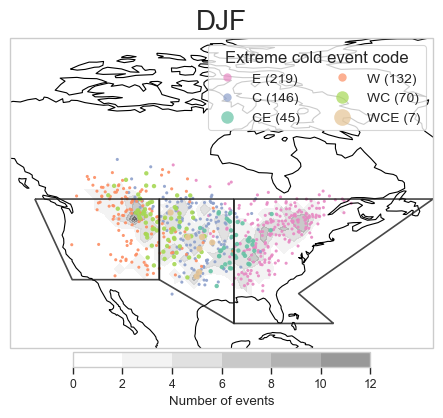

In [22]:
fig, ax = plt.subplots(1, subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
density_da_djf_nan.plot.contourf(alpha=.4, cmap='Greys', add_colorbar=True, cbar_kwargs={'pad': .01, 'shrink': .6, 'label': 'Number of events', 'orientation': 'horizontal'})
regionmask.defined_regions.ar6.land[nam_regions].plot(add_label=False, add_coastlines=False, line_kws={'alpha':0.8})
sns.scatterplot(x='lon', y='lat', data=all_t2m_centroids_djf, hue='event', size="event", ax=ax, palette=color_map, linewidth=0, alpha=.9, sizes=size_map, transform = ccrs.PlateCarree())

ax.set_extent([-135, -50, 20, 80])
lgnd = ax.legend(title="Extreme cold event code", ncols=2, fontsize=10, title_fontsize=12)
#change the marker size manually for both lines
for lgnd_handle in lgnd.legend_handles:
    lgnd_handle.set_markersize(6)
    lgnd_handle.set_alpha(.7)
lgnd.legend_handles[2].set_markersize(9)
lgnd.legend_handles[4].set_markersize(9)
lgnd.legend_handles[5].set_markersize(12)

ax.set_title("DJF", size=20)
# fig.savefig("figures/djf_centroid_plot_counts.png", dpi=300, bbox_inches='tight')

In [23]:
days_to_examine = ["2013-12-24", "2022-12-24", "CENTROID", "LEGEND"]
# days_to_examine = ["2021-12-24", "2013-12-24", "1990-12-24", "2022-12-24"]

In [24]:
lat_grid, lon_grid = np.meshgrid(extreme_low_temp['t2m_detrended']['lat'],extreme_low_temp['t2m_detrended']['lon'])
globe_land_mask = globe.is_land(lat_grid, lon_grid)

In [25]:
titles_to_use = {'000': 'no', '010': 'C', '110': 'WC', '111': 'WCE'}

In [26]:
norm = mcolors.Normalize(vmin=-1, vmax=11)  # Adjust this range to shift the colormap

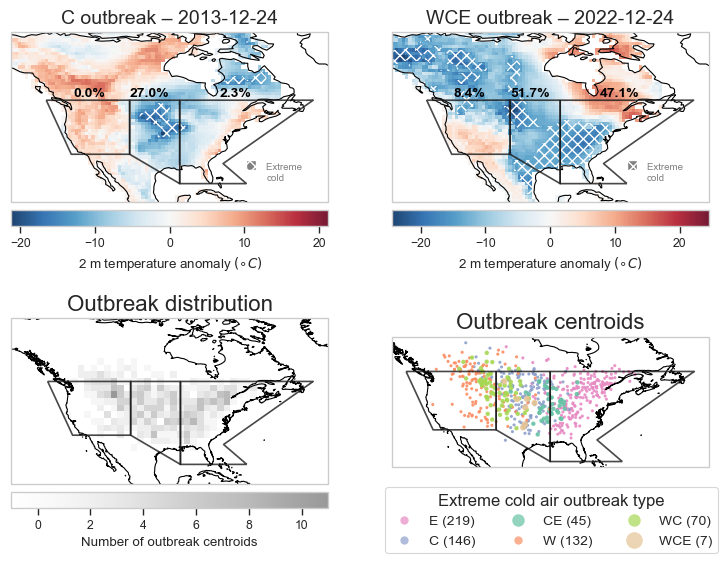

In [30]:
fig, axes = plt.subplots(2, 2, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(9, 7))

for ax, day_to_examine in zip(axes.flatten(), days_to_examine):
    if day_to_examine == 'LEGEND':
        ax.coastlines()
        sns.scatterplot(x='lon', y='lat', data=all_t2m_centroids_djf, hue='event', size="event", palette=color_map, linewidth=0, alpha=.9, sizes=size_map, transform=ccrs.PlateCarree())

        regionmask.defined_regions.ar6.land[nam_regions].plot(add_label=False, ax=ax, add_coastlines=False, line_kws={'alpha':0.8})
        # ax.set_extent([-135, -50, 20, 80])
        lgnd = ax.legend(title="Extreme cold air outbreak type", ncols=3, loc=1, bbox_to_anchor=(0.55, -0.6, 0.5, 0.5), fontsize=10, title_fontsize=12)
        #change the marker size manually for both lines
        for lgnd_handle in lgnd.legend_handles:
            lgnd_handle.set_markersize(6)
            lgnd_handle.set_alpha(.7)
        lgnd.legend_handles[2].set_markersize(9)
        lgnd.legend_handles[4].set_markersize(9)
        lgnd.legend_handles[5].set_markersize(12)
        ax.set_title("Outbreak centroids", size=16)

        # ax.remove()
    elif not day_to_examine == "CENTROID":
        one_day_t2m_detrend = t2m_detrended.sel(time=day_to_examine)
        one_day_t2m_detrend_land = one_day_t2m_detrend.where(globe_land_mask.T)
        one_day_t2m_detrend_land = one_day_t2m_detrend_land.sel(lon=slice(220-360, 300-360), lat=slice(20, 70))
        one_day_t2m_detrend_land.plot(ax=ax, alpha=.9, transform=ccrs.PlateCarree(), cbar_kwargs={'pad': .03, 'shrink': 1, 'label': '2 m temperature anomaly $(\circ C)$', 'orientation': 'horizontal'}, add_colorbar=True)
        one_day_extreme_coldairevents_ar6 = extreme_cold_persist_thresh.sel(time=day_to_examine)
        one_day_extreme_low = extreme_low_temp['t2m_detrended'].sel(time=day_to_examine)
        one_day_extreme_low = one_day_extreme_low.where(globe_land_mask.T)
        one_day_extreme_low.load()
        one_day_extreme_low = one_day_extreme_low.where(lambda row: row > 0)
        one_day_extreme_low = one_day_extreme_low.sel(lon=slice(220-360, 300-360), lat=slice(20, 70))
        # one_day_extreme_low.plot(ax=ax, cmap='cividis', alpha=.7, add_colorbar=False, transform=ccrs.PlateCarree()) 
        
        stipple_mask = one_day_extreme_low
        ax.contourf(
            one_day_extreme_low.lon, one_day_extreme_low.lat, stipple_mask,
            levels=[0.5, 1],
            hatches=['xxx'],  # stippling pattern
            colors='none',     # transparent
            transform=ccrs.PlateCarree()
        )
            
        one_day_extreme_coldairevents_ar6.load()
        wna_coverage = one_day_extreme_coldairevents_ar6['wna_perc_coverage'].data
        cna_coverage = one_day_extreme_coldairevents_ar6['cna_perc_coverage'].data
        ena_coverage = one_day_extreme_coldairevents_ar6['ena_perc_coverage'].data
        ax.text(s=f"{wna_coverage:.1f}%", x=-122, y=51, color='k', fontweight='bold', size=10)
        ax.text(s=f"{cna_coverage:.1f}%", x=-105, y=51, color='k', fontweight='bold', size=10)
        ax.text(s=f"{ena_coverage:.1f}%", x=-78, y=51, color='k', fontweight='bold', size=10)
        ax.coastlines()
        code_str = str(one_day_extreme_coldairevents_ar6['cold_air_event_stacked_names'].data)
        title_to_use = f"{code_str[0]}-{code_str[1]}-{code_str[2]}"
        ax.set_title(f"{titles_to_use[code_str]} outbreak – {day_to_examine}", size=14)
        regionmask.defined_regions.ar6.land[nam_regions].plot(add_label=False, ax=ax, add_coastlines=False, line_kws={'alpha':0.8})
    else:
        ax.coastlines()
        density_da_djf_nan.plot(alpha=.4, transform=ccrs.PlateCarree(), cmap='Greys', norm=norm, ax=ax, add_colorbar=True, cbar_kwargs={'pad': .03, 'shrink': 1, 'label': 'Number of outbreak centroids', 'orientation': 'horizontal'})
        regionmask.defined_regions.ar6.land[nam_regions].plot(add_label=False, ax=ax, add_coastlines=False, line_kws={'alpha':0.8})
        ax.set_title("Outbreak distribution", size=16)

        # ax.set_title("DJF", size=20)
    
for ax in axes[0]:
    # ax.plot([-67, -68], [30, 30],
    #      color='grey', linewidth=2, marker='s',
    #      transform=ccrs.Geodetic(),
         # )
    from cartopy.feature import ShapelyFeature
    from shapely.geometry import Polygon

    # Define your box coordinates (lon, lat) in counter-clockwise order
    box_coords = [(-70, 29), (-67, 29), (-67, 32), (-70, 32)]
    
    # Create a Shapely polygon
    box_poly = Polygon(box_coords)
    
    # Wrap it as a Cartopy feature with hatching
    hatch_feature = ShapelyFeature(
        [box_poly],
        ccrs.PlateCarree(),
        facecolor='grey',   
        edgecolor='white',
        hatch='xxx',           # Stipple pattern
        linewidth=1
    )
    
    # Add it to the axes
    ax.add_feature(hatch_feature)
    ax.text(s="Extreme \ncold", x=-64, y=26, color='grey', size=7)

    
fig.subplots_adjust(hspace=.1)
# fig.savefig('figures/coldairevent_comparison_24Dec_w_centroids_stippling.png', dpi=300, bbox_inches='tight')